# Tensor Hypercontraction

SELECT and PREPARE for the second quantized Tensor Hypercontracted (THC) chemistry Hamtiltonian.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `UniformSuperpositionTHC`
Prepare uniform superposition state for THC.

$$
    |0\rangle^{\otimes 2\log(M+1)} \rightarrow \sum_{\mu\le\nu}^{M} |\mu\rangle|\nu\rangle
    + \sum_{\mu}^{N/2}|\mu\rangle|\nu=M+1\rangle,
$$

where $M$ is the THC auxiliary dimension, and $N$ is the number of spin orbitals.

The toffoli complexity of this gate should be $10 \log(M+1) + 2 b_r - 9$.
Currently it is a good deal larger due to:
 1. inverting inequality tests should not need more toffolis.
 2. We are not using phase-gradient gate toffoli cost for Ry rotations.
 3. Small differences in quoted vs implemented comparator costs.

See: https://github.com/quantumlib/Qualtran/issues/390

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$ 

#### Registers
 - `mu`: $\mu$ register.
 - `nu`: $\nu$ register.
 - `succ`: ancilla flagging success of amplitude amplification.
 - `nu_eq_mp1`: ancillas for flagging if $\nu = M+1$.
 - `rot`: The ancilla to be rotated for amplitude amplification. 

#### References
 - [Even more efficient quantum computations of chemistry through     tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf). Eq. 29.


In [2]:
from qualtran.bloqs.chemistry.thc import UniformSuperpositionTHC

### Example Instances

In [3]:
num_mu = 10
num_spin_orb = 4
thc_uni = UniformSuperpositionTHC(num_mu=num_mu, num_spin_orb=num_spin_orb)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([thc_uni],
           ['`thc_uni`'])

### Call Graph

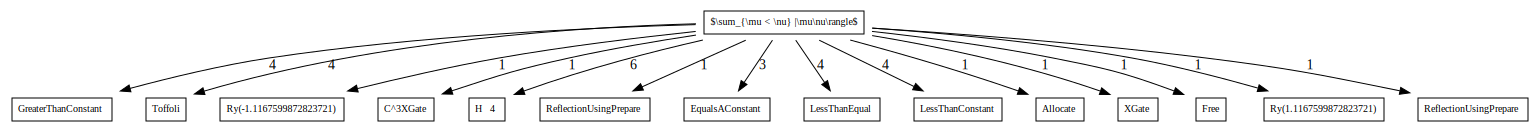

#### Counts totals:
 - `Allocate`: 1
 - `C^3XGate`: 1
 - `EqualsAConstant`: 3
 - `Free`: 1
 - `GreaterThanConstant`: 4
 - `H⨂4`: 6
 - `LessThanConstant`: 4
 - `LessThanEqual`: 4
 - `ReflectionUsingPrepare`: 1
 - `ReflectionUsingPrepare`: 1
 - `Ry(-1.1167599872823721)`: 1
 - `Ry(1.1167599872823721)`: 1
 - `Toffoli`: 4
 - `XGate`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
thc_uni_g, thc_uni_sigma = thc_uni.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(thc_uni_g)
show_counts_sigma(thc_uni_sigma)

### Flame Graph

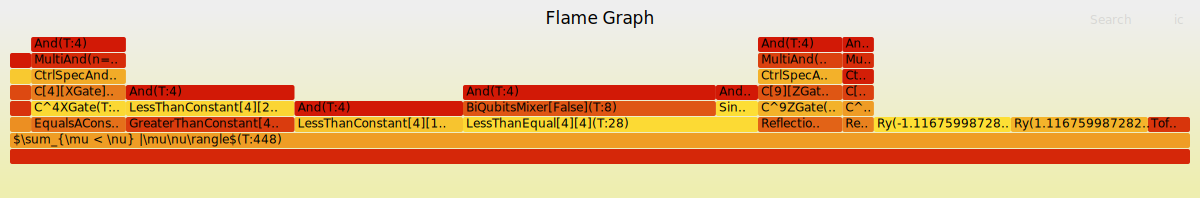

In [6]:
from qualtran.drawing import show_flame_graph
show_flame_graph(thc_uni)

Let's print out the costs contributing to the TCount.

In [7]:
from qualtran.resource_counting.classify_bloqs import classify_t_count_by_bloq_type

binned_counts = classify_t_count_by_bloq_type(thc_uni)

# number of bits for mu register (nm in THC paper)
# note this register should range up to num_mu + 1, not num_mu, hence it's just bit_length not (num_mu - 1).bit_length()
nm = thc_uni.num_mu.bit_length()
# Costs for THC paper
# The factor of 4 is for Toffoli -> T conversion
paper_costs = {
    'arithmetic': 4*(4*(nm - 1) + (4*nm - 3)), # 4 comparitors of cost nm - 1 Toffolis
    'rotations': 4*(4 + 4), # Given as br - 3, br = 7 is the number of bits of precision for rotations.
    'reflection': 4*(3 + 2*nm-1), # 5 qubit reflection for comparitors and 2*nm + 1 qubits reflect after hadamards
    'other': 4*3, # "Checking the inequality test" unclear if this is the multi-control not gate.
}
for k in (paper_costs.keys() | binned_counts.keys()):
    print(f"{k+':':15s} qualtran = {binned_counts.get(k,0):5d} vs paper cost = {paper_costs.get(k,0):5d}.")

assert binned_counts['arithmetic'] == 276

other:          qualtran =     0 vs paper cost =    12.
rotations:      qualtran =    22 vs paper cost =    32.
arithmetic:     qualtran =   276 vs paper cost =   100.
multi_control_pauli: qualtran =     8 vs paper cost =     0.
reflection:     qualtran =    44 vs paper cost =    40.
toffoli:        qualtran =    16 vs paper cost =     0.


The discrepancies arise from the following issues:

1. Comparators: The paper uncomputes the comparators at zero Toffoli cost, whereas we do not. This is nearly a factor of two difference. This leaves us with 144 vs 100. The extra factor of 44 arises from the different costs of the comparators listed in the paper and those in qualtran. The paper uses a cost of $n_m - 1$ for all the comparitors (with the final $\nu = M+1$ equality test costing $n_m$), whereas the qualtran comparators assume a cost of $n_m - 1$ for equality testing to a classical value, $n_m$ for comparison to a classical value and $2 n_m - 1$ when comparing two quantum registers.
2. Rotations: The paper uses a phase gradient register which has a much lower cost than the qualtran cost which assumes a generic synthesis cost. 
3. Reflections and other: This discrepancy arises because the paper states the first reflection in between the comparators has Toffoli cost of 3, rather than what we have which is 2 Toffolis and 1 Multi-Controlled Z which costs 2 Toffolis. Our costs for the second reflection match. The other discrepancy is for the operations in between the second set of comparators. Here we count 2 Toffolis and 1 Multi-Controlled-Not gate of cost 2 Toffolis.  

The leading order Toffoli cost of this state preparation is 10 $n_m$ in the paper which arises from the comparators and the reflection on the $\mu$ and $\nu$ registers, i.e. $4(n_m - 1) + 4n_m - 3 + 2n_m -1 \approx 10 n_m$.

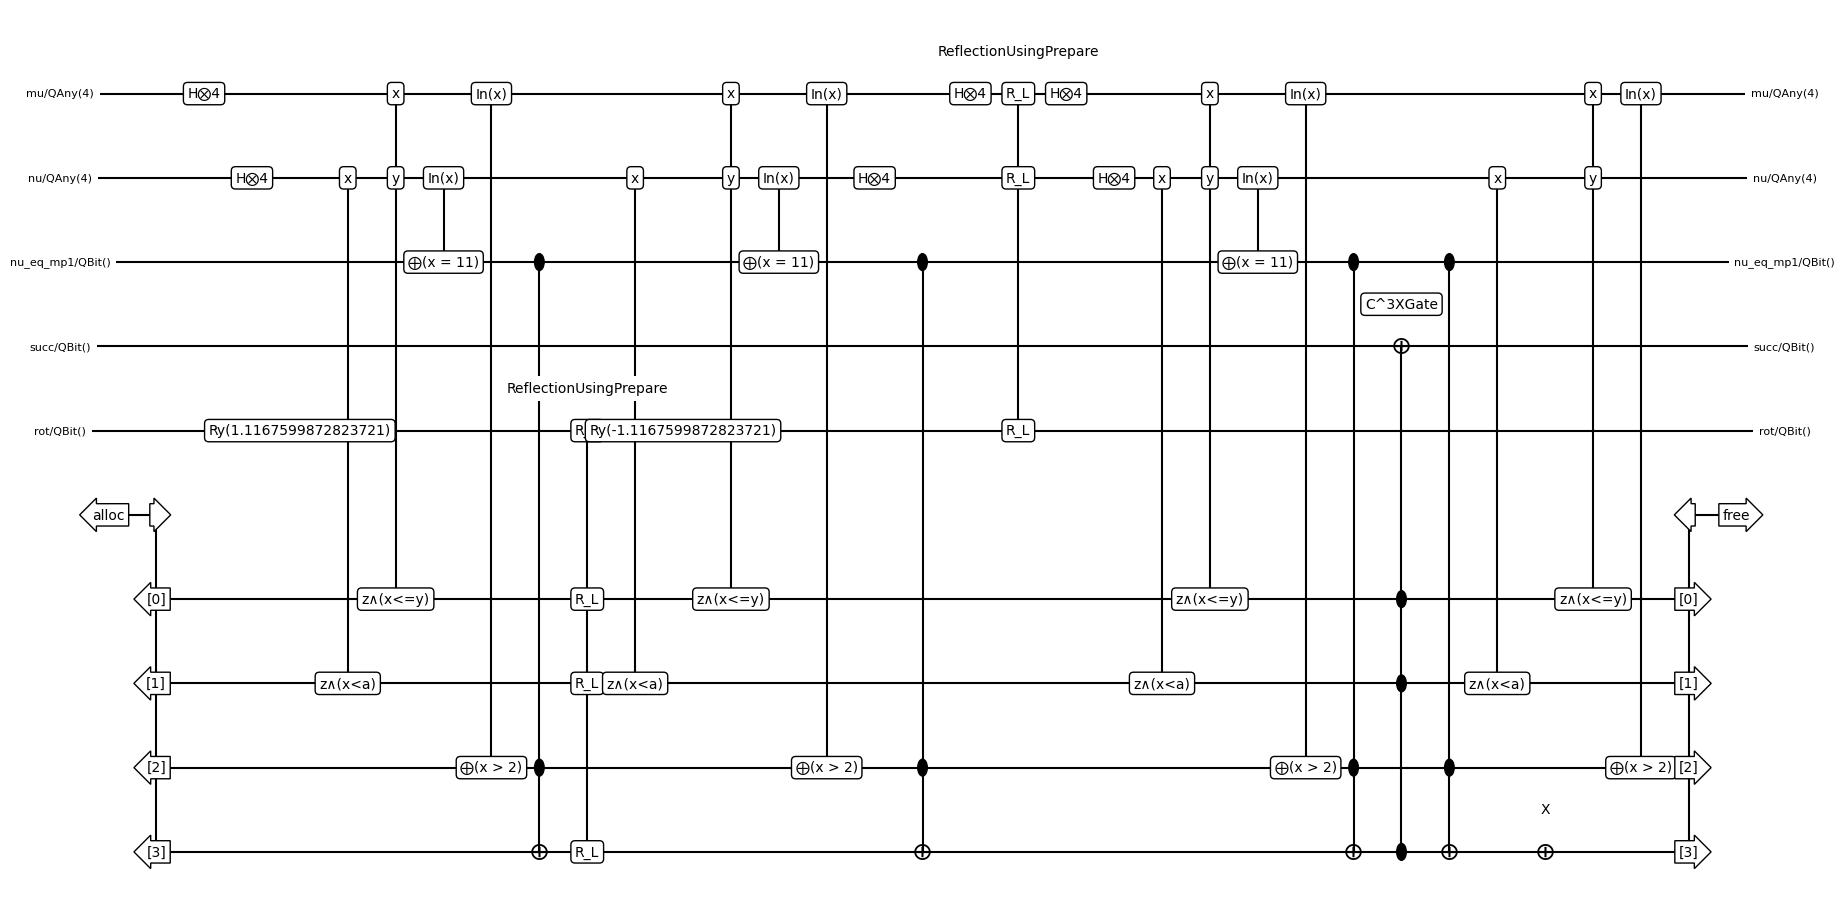

In [8]:
from qualtran.drawing.musical_score import draw_musical_score, get_musical_score_data

msd = get_musical_score_data(thc_uni.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(20, 10)

## `PrepareTHC`
State Preparation for THC Hamilontian.

Prepares the state

$$
    \frac{1}{\sqrt{\lambda}}|+\rangle|+\rangle\left[
        \sum_\ell^{N/2} \sqrt{t_\ell}|\ell\rangle|M+1\rangle
        + \frac{1}{\sqrt{2}} \sum_{\mu\le\nu}^M \sqrt{\zeta_{\mu\nu}} |\mu\rangle|\nu\rangle
    \right].
$$

Note we use UniformSuperpositionTHC as a subroutine as part of this bloq in
contrast to the reference which keeps them separate.

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$
 - `alt_mu`: Alternate values for mu indices.
 - `alt_nu`: Alternate values for nu indices.
 - `alt_theta`: Alternate values for theta indices.
 - `theta`: Signs of lcu coefficients.
 - `keep`: keep values.
 - `keep_bitsize`: number of bits for keep register for coherent alias sampling. 

#### Registers
 - `mu`: $\mu$ register.
 - `nu`: $\nu$ register.
 - `plus_mn`: plus state for controlled swaps on mu/nu.
 - `plus_a / plus_b`: plus state for controlled swaps on spins.
 - `sigma`: ancilla register for alias sampling.
 - `rot`: ancilla register for rotation for uniform superposition state.
 - `succ`: success flag qubit from uniform state preparation
 - `nu_eq_mp1`: flag for if $nu = M+1$
 - `theta`: sign register.
 - `s`: Contiguous index register.
 - `alt_mn`: Register to store alt mu and nu values.
 - `alt_theta`: Register for alternate theta values.
 - `keep`: keep_bitsize-sized register for the keep values from coherent alias sampling.
 - `less_than`: Single qubit ancilla for alias sampling.
 - `extra_ctrl`: An extra control register for producing a multi-controlled CSwap. 

#### References
 - [Even more efficient quantum computations of chemistry through     tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf). Fig. 2 and Fig. 3.


In [9]:
from qualtran.bloqs.chemistry.thc import PrepareTHC

### Example Instances

In [10]:
from qualtran.bloqs.chemistry.thc.prepare_test import build_random_test_integrals

num_spat = 4
num_mu = 8
t_l, eta, zeta = build_random_test_integrals(num_mu, num_spat, seed=7)
thc_prep = PrepareTHC.from_hamiltonian_coeffs(
    t_l, eta, zeta, num_bits_state_prep=8, log_block_size=2
)

#### Graphical Signature

In [11]:
from qualtran.drawing import show_bloqs
show_bloqs([thc_prep],
           ['`thc_prep`'])

### Call Graph

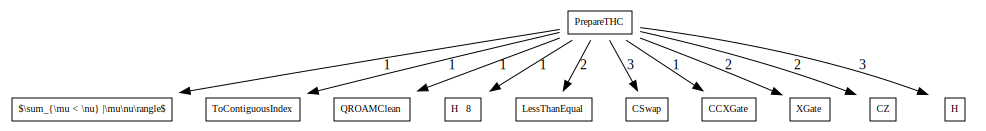

#### Counts totals:
 - `$\sum_{\mu < \nu} |\mu\nu\rangle$`: 1
 - `CCXGate`: 1
 - `CSwap`: 3
 - `CZ`: 2
 - `H`: 3
 - `H⨂8`: 1
 - `LessThanEqual`: 2
 - `QROAMClean`: 1
 - `ToContiguousIndex`: 1
 - `XGate`: 2

In [12]:
from qualtran.resource_counting.generalizers import ignore_split_join
thc_prep_g, thc_prep_sigma = thc_prep.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(thc_prep_g)
show_counts_sigma(thc_prep_sigma)

### Flame Graph

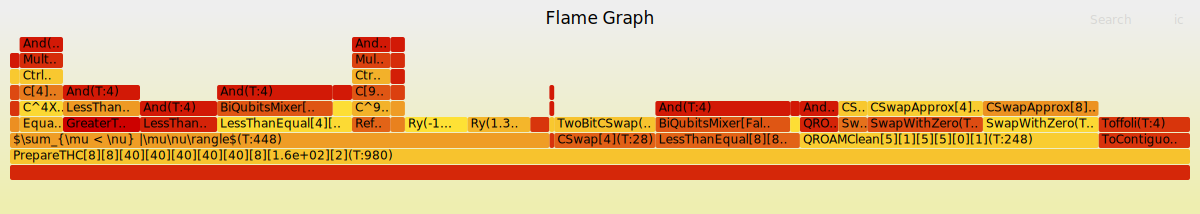

In [13]:
from qualtran.drawing import show_flame_graph
show_flame_graph(thc_prep)

### Paper Comparison

Let's compare our costs to those from the paper. Note we will only look at the cost of prepare. Inverting prepare has the same cost up to the cost of the inverse QROM being reduced to

$$
\lceil \frac{d}{k_{s2}} \rceil + k_{s2}
$$


In [14]:
binned_counts = classify_t_count_by_bloq_type(thc_prep.decompose_bloq())
data_size = thc_prep.num_mu * (thc_prep.num_mu + 1) // 2 + thc_prep.num_spin_orb // 2

num_bits_mu = thc_prep.num_mu.bit_length() 
qrom_bitsize = 2 * num_bits_mu + 2 + thc_prep.keep_bitsize
paper_costs = {
    'arithmetic': 4*(num_bits_mu ** 2 + num_bits_mu - 1) + 4*thc_prep.keep_bitsize,
    'swaps': 4*(2 * num_bits_mu + (num_bits_mu + 1)), # Swaps from inequality and swap from from 
    'data_loading': 4 * (int(np.ceil(data_size/4) + qrom_bitsize * (4 - 1))), # Eq. 31 from THC paper, k = 4 in this specific case.
}
for k, v in paper_costs.items():
    print(f"{k+':':20s} qualtran = {binned_counts[k]:5d} vs paper cost = {v:5d}.")

print(f"Total cost = {sum(v for v in binned_counts.values())}")
assert binned_counts['data_loading'] == 248

arithmetic:          qualtran =   472 vs paper cost =   108.
swaps:               qualtran =    84 vs paper cost =    52.
data_loading:        qualtran =   248 vs paper cost =   256.
Total cost = 898


The main discrepancies arise the differences in comparator cost seen before. The QROAM cost in qualtran is more accurate as it includes the constant factor of -2 Toffolis arising from uncontrolled QROM. 

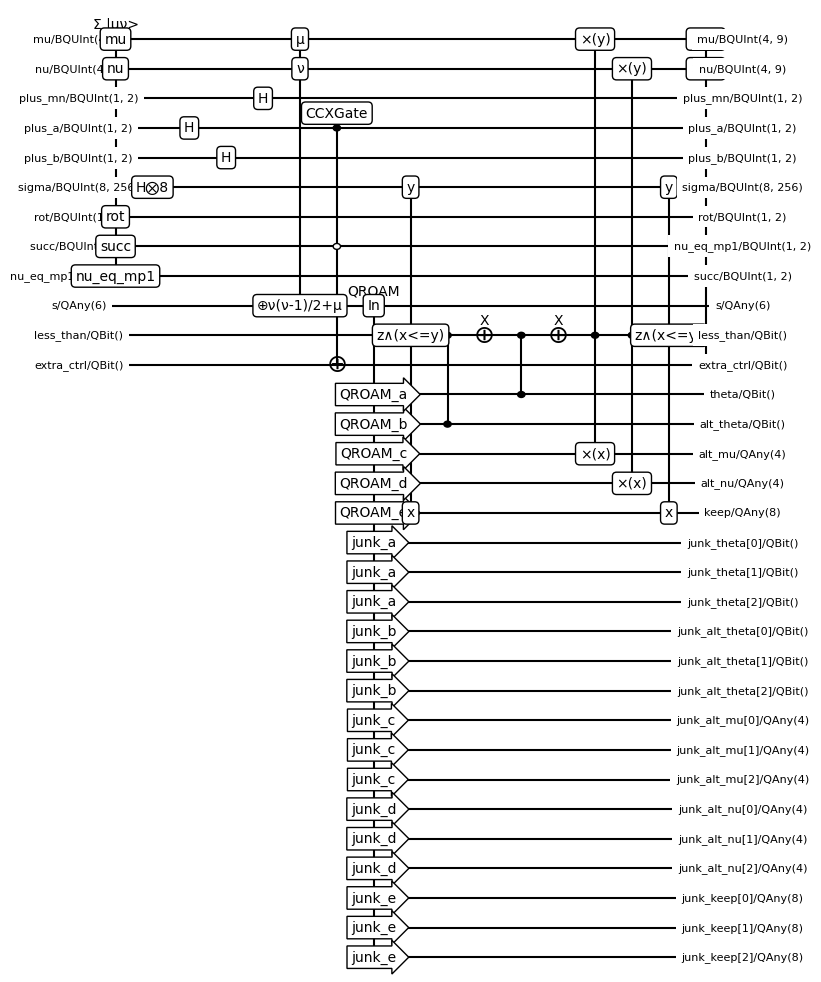

In [15]:
from qualtran.drawing.musical_score import draw_musical_score, get_musical_score_data


msd = get_musical_score_data(thc_prep.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_size_inches(10, 10)

## `SelectTHC`
SELECT for THC Hamiltonian.

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$
 - `num_bits_theta`: Number of bits of precision for the rotations. Called $\beth$ in the reference.
 - `kr1`: block sizes for QROM erasure for outputting rotation angles. See Eq 34.
 - `kr2`: block sizes for QROM erasure for outputting rotation angles. This is for the second QROM (eq 35)
 - `control_val`: A control bit for the entire gate.
 - `keep_bitsize`: number of bits for keep register for coherent alias
 - `sampling. This can be determined from the PrepareTHC bloq. See`: 
 - `https`: //github.com/quantumlib/Qualtran/issues/549 

#### Registers
 - `succ`: success flag qubit from uniform state preparation
 - `nu_eq_mp1`: flag for if $nu = M+1$
 - `mu`: $\mu$ register.
 - `nu`: $\nu$ register.
 - `theta`: sign register.
 - `plus_mn`: Flag controlling swaps between mu and nu. Note that as per the Reference, the swaps are NOT performed as part of SELECT as they're acounted for during Prepare.
 - `plus_a / plus_b`: plus state for controlled swaps on spins.
 - `sys_a / sys_b`: System registers for (a)lpha/(b)eta orbitals. 

#### References
 - [Even more efficient quantum computations of chemistry through     tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf). Fig. 7.


In [16]:
from qualtran.bloqs.chemistry.thc import SelectTHC

### Example Instances

In [17]:
num_mu = 8
num_mu = 10
num_spin_orb = 2 * 4
thc_sel = SelectTHC(
    num_mu=num_mu, num_spin_orb=num_spin_orb, num_bits_theta=12, keep_bitsize=10
)

#### Graphical Signature

In [18]:
from qualtran.drawing import show_bloqs
show_bloqs([thc_sel],
           ['`thc_sel`'])

### Call Graph

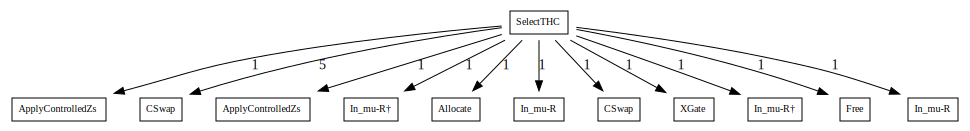

#### Counts totals:
 - `Allocate`: 1
 - `ApplyControlledZs`: 1
 - `ApplyControlledZs`: 1
 - `CSwap`: 1
 - `CSwap`: 5
 - `Free`: 1
 - `In_mu-R`: 1
 - `In_mu-R`: 1
 - `In_mu-R†`: 1
 - `In_mu-R†`: 1
 - `XGate`: 1

In [19]:
from qualtran.resource_counting.generalizers import ignore_split_join
thc_sel_g, thc_sel_sigma = thc_sel.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(thc_sel_g)
show_counts_sigma(thc_sel_sigma)

### Flame Graph

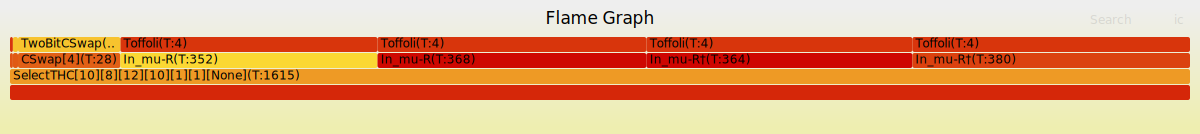

In [20]:
from qualtran.drawing import show_flame_graph
show_flame_graph(thc_sel)